In [1]:
########## Imports ##########
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

import fonctions
from packages import cost

from sklearn.model_selection import train_test_split

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
#!brew install cmake libomp
#!pip install lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 200)

In [2]:
########## Import des données ##########

path = '' #-> en local
filepath = os.path.join(path, 'data/df_train')

with open(filepath, 'rb') as f:
    df = pickle.load(f)

df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM,PREV_APPL_MEAN_CARD_MEAN_SK_DPD,PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION,PREV_

In [3]:
filepath = os.path.join(path, 'data/target')

with open(filepath, 'rb') as f:
    df_target = pickle.load(f)

df_target.head()

SK_ID_CURR
100002    1
100003    0
100004    0
100006    0
100007    0
Name: TARGET, dtype: int64

In [4]:
# Séparation en train et en test

X = df
y = df_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [5]:
# on remet la target dans les données ?
#X_train['TARGET'] = y_train
#X_test['TARGET'] = y_test

In [6]:
print('train shape :', X_train.shape)
print('test shape :', X_test.shape)

train shape : (232842, 175)
test shape : (58211, 175)


In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((232842, 175), (58211, 175), (232842,), (58211,))

In [8]:
# ici :
# -> données avec labels -> Supervised Learning
# -> 0/1 (variable discrète) -> Classification

### Fonction de coût

In [9]:
######### Analyse des erreurs de prédiction ########

# - FP (False Positive) :
# = quand la prédiction est positive, mais la valeur réelle est négative
# va induire une perte réelle si le crédit client accepté se transforme en défaut de paiement. -> PENALITE DE 10

# - FN (False Negative) :
# = quand la prédiction est négative, mais la valeur réelle est positive
# va induire une perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé. -> PENALITE DE 1

# les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.

# L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN.
# On part du F-Score, mesure de la performance d'un modèle de classification qui combine les mesures de précision et de rappel, elles mêmes basées sur les taux de vrais positifs, faux positifs et faux négatifs
# (donc va être idéal à adapter dans notre cas)

# cf cost.py

### Regression logistique

In [10]:
### Logistic Regression

# Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc…
# La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit.
# Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [11]:
# Régression Logistique
lr = LogisticRegression()
lr.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7433
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     53329
           1       0.53      0.01      0.03      4882

    accuracy                           0.92     58211
   macro avg       0.72      0.51      0.49     58211
weighted avg       0.88      0.92      0.88     58211



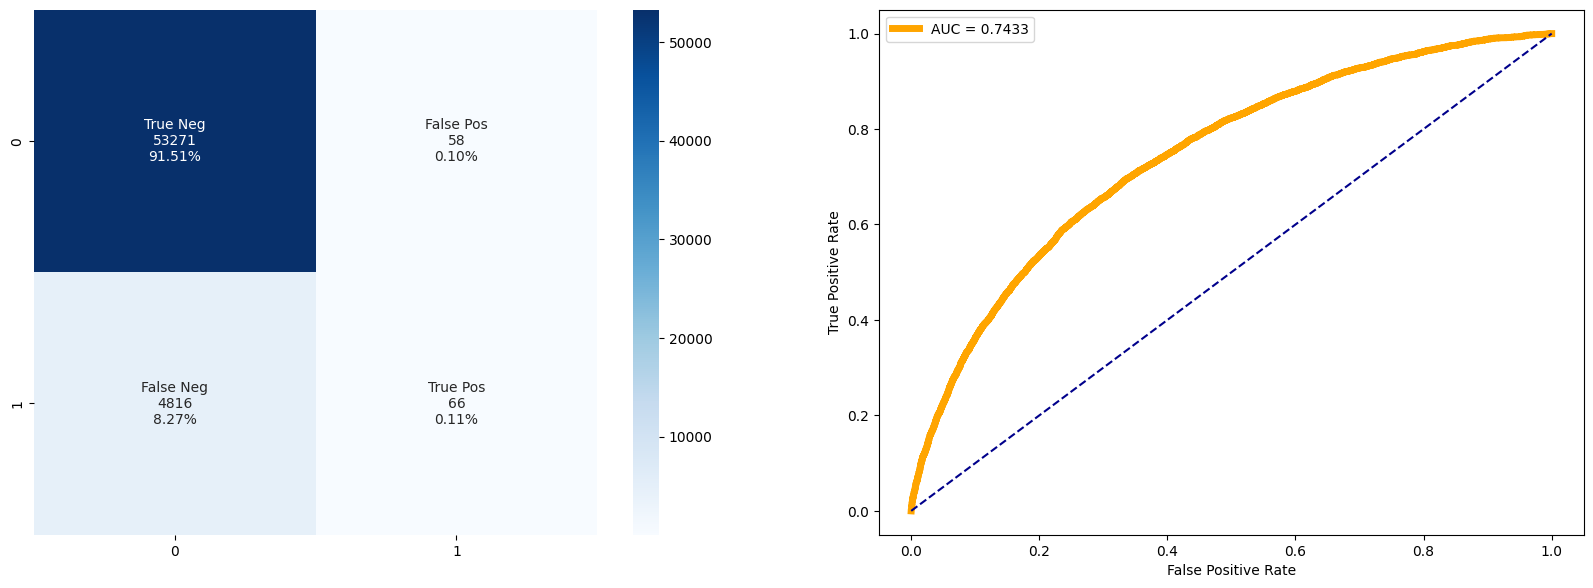

In [12]:
fonctions.cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], roc_auc)

In [13]:
cost.custom_metric(y_test, lr.predict(X_test))

5103

In [14]:
# AUC = Area Under the Curve ROC
# courbe ROC : Recall in y-axis and 1-Specificity in x-axis

# -> indicates how well the probabilities from the positive classes are separated from the negative classes
# 0,5 -> 50%/50% -> le marqueur est non informatif
# entre 0,5 et 1,0 -> discrimination

In [15]:
####### mhhhhhhhhhh
# surement un problème lié au déséquilibre des classes

# 2 options :
# - undersampling : Parmi les individus majoritaires, on en retire une partie afin d’accorder plus d’importance aux individus minoritaires
# - oversampling : Le nombre d’individus minoritaires est augmenté pour qu’ils aient plus d’importance lors de la modélisation

# pour l'oversampling : différentes solutions sont possibles, comme le “clonage” aléatoire ou le SMOTE

In [16]:
# SMOTE
# = Synthetic Minority Oversampling TEchnique
# = méthode de suréchantillonnage des observations minoritaires

# https://kobia.fr/imbalanced-data-smote/

In [17]:
# Définition de l'instance SMOTE
sm = SMOTE(
    k_neighbors = 3, # nombre de plus proches voisins
    sampling_strategy = 0.75, # taux d'observatios minoritaires à atteindre
    random_state = 0
    )

# Application du SMOTE aux données
X_smote, y_smote = sm.fit_resample(X, y)

In [18]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 0)

In [19]:
# on remet la target dans les données ?
#X_train_smote['TARGET'] = y_train_smote
#X_test_smote['TARGET'] = y_test_smote

In [20]:
# Régression Logistique
lr = LogisticRegression()
lr.fit(X_train_smote, y_train_smote)

roc_auc = roc_auc_score(y_test_smote, lr.predict_proba(X_test_smote)[:, 1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test_smote, lr.predict(X_test_smote)))

AUC : 0.7621
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     53701
           1       0.67      0.58      0.62     39822

    accuracy                           0.70     93523
   macro avg       0.69      0.68      0.69     93523
weighted avg       0.70      0.70      0.69     93523



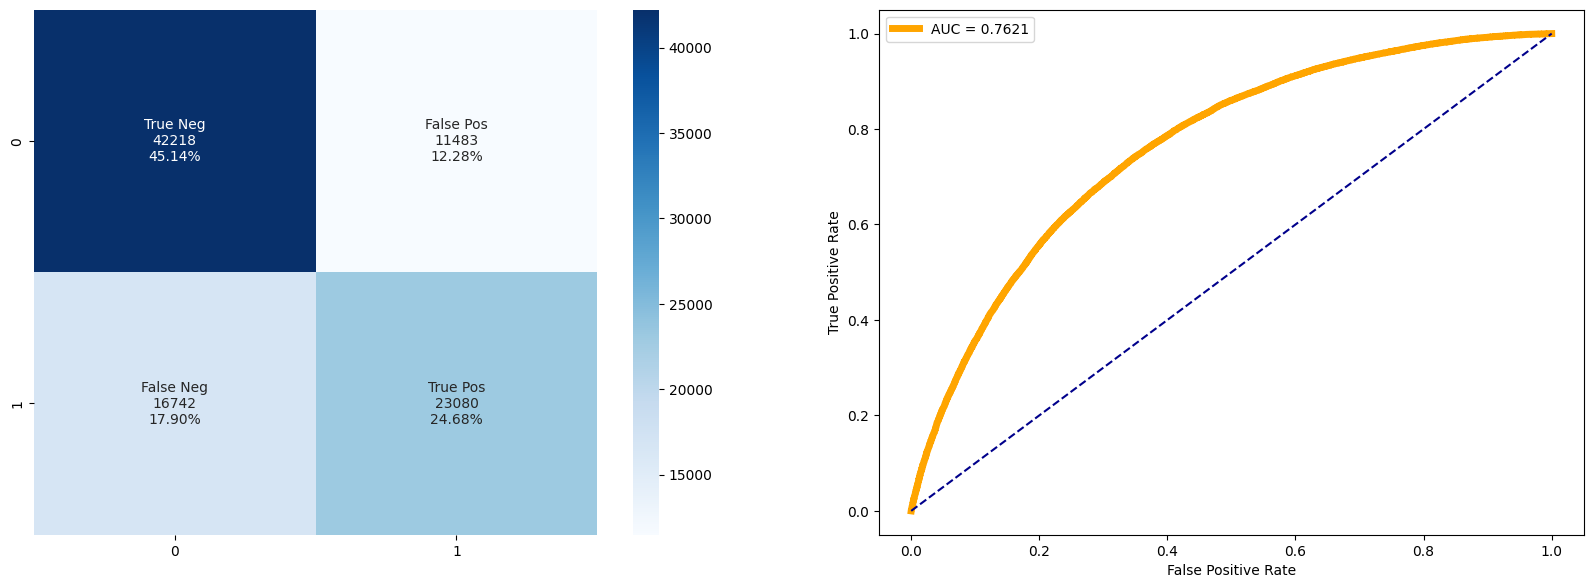

In [21]:
fonctions.cf_matrix_roc_auc(lr, y_test_smote, lr.predict(X_test_smote), lr.predict_proba(X_test_smote)[:, 1], roc_auc)

In [22]:
cost.custom_metric(y_test_smote, lr.predict(X_test_smote))

-136799

In [23]:
# mhhhhhhh

### Autres modèles

In [24]:
#!pip install catboost

In [25]:
# Modèles à tester

"""
models = [
          CatBoostClassifier(task_type = 'GPU', logging_level = 'Silent'),
          LGBMClassifier(device = 'gpu'),
          XGBClassifier(tree_method = 'gpu_hist', predictor = 'gpu_predictor')
          ]"""

"\nmodels = [\n          CatBoostClassifier(task_type = 'GPU', logging_level = 'Silent'),\n          LGBMClassifier(device = 'gpu'),\n          XGBClassifier(tree_method = 'gpu_hist', predictor = 'gpu_predictor')\n          ]"

In [26]:
from sklearn.dummy import DummyClassifier # modèle baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [27]:
models = [
    DummyClassifier(), # modèle baseline
    KNeighborsClassifier(), # k-nearest neighbors
    LogisticRegression(), # Regression logistique
    GaussianNB(), # Naives Bayes
    SVC(), # -> long !! # Support Vector Machines
    CatBoostClassifier(logging_level = 'Silent'),
    LGBMClassifier(),
    DecisionTreeClassifier(), # Arbres de decision
    RandomForestClassifier(), # random forest
    AdaBoostClassifier(),
    GradientBoostingClassifier(), # gradient boosting
    xgb.XGBClassifier(), # XGBoost
    #XGBClassifier() # -> erreur !
    ]

In [28]:
# Fonction pour calculer les métriques auc, accuracy, f1, precision et recall

def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      'Custom' : cost.custom_metric(y_test, model.predict(X_test))
      }

    return output

In [29]:
# Boucler sur les modèles et évaluer

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models:
    print(type(model).__name__)
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Initialise data of lists
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)

base_models

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
SVC


In [ ]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Custom,Time
1,CatBoostClassifier,0.768282,0.91603,0.491713,0.03646,0.067887,1.79933,38.950313
2,LGBMClassifier,0.763242,0.916356,0.532995,0.021508,0.041347,1.816993,4.123366
0,LogisticRegression,0.743299,0.91627,0.532258,0.013519,0.026368,1.826977,6.435812


In [ ]:
stop

In [ ]:
models2 = [
    #LogisticRegression(),
    #SVC(), # -> long !!
    #CatBoostClassifier(logging_level = 'Silent'),
    #LGBMClassifier(),
    XGBClassifier() # -> erreur !
    ]

# Boucler sur les modèles et évaluer

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models2:
    print(type(model).__name__)
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Initialise data of lists
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)

base_models

XGBClassifier


/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AttributeError: module 'pandas' has no attribute 'Int64Index'

In [ ]:
#pip install --upgrade pandas

In [ ]:
models3 = XGBClassifier(tree_method = 'gpu_hist', predictor = 'gpu_predictor')
results = train_models(models3, X_train, X_test, y_train, y_test)

/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AttributeError: module 'pandas' has no attribute 'Int64Index'

In [ ]:
# essayer de trouver solution mais si je galère vraiment trop je laisse tomber
# comparer 3-5 modèles

In [ ]:
# Idem mais avec SMOTE

X_smote, y_smote = sm.fit_resample(X, y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 0)

# Boucler sur les modèles et évaluer

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models:
    print(type(model).__name__)
    start = time.time()
    results = train_models(model, X_train_smote, X_test_smote, y_train_smote, y_test_smote)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Initialise data of lists
base_models_smote = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models_smote.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models_smote.sort_values('AUC', ascending = False, inplace = True)

base_models_smote

LogisticRegression


/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CatBoostClassifier
LGBMClassifier


,Model,AUC,Accuracy,Precision,Recall,F1,Custom,Time
1,CatBoostClassifier,0.972689,0.948761,0.994188,0.884838,0.936331,4.131845,64.206596
2,LGBMClassifier,0.970968,0.948152,0.997666,0.880292,0.935311,4.37474,8.470688
0,LogisticRegression,0.762132,0.698203,0.667766,0.579579,0.620555,-0.796085,11.685123


In [ ]:
# modèle baseline
# prets attribués de manière aléatoire
# dummy classifier

In [ ]:
# choisir un seul modèle et le fine tuner (eventuellement deux si j'ai un doute)

In [ ]:
# Make scorer
# -> permet de définir dans quel "sens" prendre notre nouvelle métrique (ici, plus la valeur est grande, mieux c'est)
from sklearn.metrics import make_scorer
custom_score = make_scorer(cost.custom_metric, greater_is_better = True)
custom_score

make_scorer(custom_metric)

In [ ]:
# ne pas oublier de sauvegarder à chaque fois les résultats dans mlflow
# si je le fais une fois pour toute ça va aussi

In [ ]:
# feature importance
# par exemple shap
# certains modèles comme random forest le font direct